In [1]:
import pickle
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

## LOAD RESULTS

In [7]:
# TSSPlant
p = '/content/drive/MyDrive/Mag naloga/EPFL/repo_koda/MultiTSS/Data/tss_plantchr3POZ.res'
with open(p, 'r') as f: data = f.read().split('\n')
tssplant = []
for i in range(len(data)):
  l = data[i]
  if l.startswith('Query'):
    name, start = l[l.index('>'):l.index('<')].split('_')
    start = int(start)
    for j in range(i+3, len(data)):
      lj = data[j]
      if not lj.startswith('TSS') and not lj.startswith('(TATA'): break
      if lj.startswith('TSS'):
        pos = int(lj[:lj.index('TSS score')].replace('TSS position:', ''))
        score = float(lj[lj.index('TSS score'):lj.index('TATA-box position')].replace('TSS score =', ''))
        tatapos = int(lj[lj.index('TATA-box position'):lj.index('TATA-box score')].replace('TATA-box position:', ''))
        tatascore = float(lj[lj.index('TATA-box score'):].replace('TATA-box score =', ''))
        # print(pos, ',', score,',', tatapos, ',',tatascore)
        tssplant.append({'TSS': pos+start, 'TSS score': score, 'TATA': tatapos+start, 'TATA score': tatascore})
      else:
        lj = lj.replace('(TATA-) ', '')
        pos = int(lj[:lj.index('TSS score')].replace('TSS position:', ''))
        score = float(lj[lj.index('TSS score'):].replace('TSS score =', ''))
        tssplant.append({'TSS': pos+start, 'TSS score': score})
        #print(pos,',', score)
tss_plant = pd.DataFrame(tssplant).sort_values(by=['TSS'])
tss_plant.sample(4)

,TSS,TSS score,TATA,TATA score
18878,8880861,1.9310,8864555.0,6.5002
13050,6063399,-1.6407,6083589.0,3.8148
42439,19900505,-1.7034,NaN,NaN
17136,8021660,0.7893,8044331.0,5.9238


In [9]:
# TSSFinder
p = '/content/drive/MyDrive/Mag naloga/EPFL/repo_koda/MultiTSS/Data/out.tss.bed'
tssfinder = pd.read_csv(p, sep='\t', header=None).drop([0, 2, 3, 4], axis=1).sort_values(by=[1])
tssfinder.sample(4)

,1,5
1631,11311352,+
2031,18291454,+
778,5166462,+
1215,7899168,+


In [11]:
# my method
# BORDERS: last bin not here
# 0.3
p = '/content/drive/MyDrive/Mag naloga/EPFL/repo_koda/MultiTSS/Data/MODEL_Chr3_GEN_modelencdec_class_data_myMSE_toggleAdamW_myMSEloss__21_43_50_6_testlocNONORM.pkl'
data = pd.read_pickle(p)
gffmodel = []
for chr, start, output in data:
  gffmodel.append({'start':start, 'binstart':start+448*128, 'binend':start+449*128, 'bin': output})
gffmodel = pd.DataFrame(gffmodel).sort_values(by=['start'])
gffmodel.sample(4)

,start,binstart,binend,bin
86510,12271744,12329088,12329216,"[0.07037084, -0.32243022, -0.2742083, -0.72217..."
53224,16532352,16589696,16589824,"[0.851557, 0.3779087, 0.5998568, 0.84555, 1.38..."
136860,5826944,5884288,5884416,"[-0.94986284, -1.0945404, -2.093939, -1.946832..."
60978,15539840,15597184,15597312,"[-0.522292, -1.3784115, -1.4190679, -1.4329519..."


In [20]:
# my method
# > 0.4
# BORDERS: last bin not here
p = '/content/drive/MyDrive/Mag naloga/EPFL/repo_koda/MultiTSS/Data/MODEL_Chr3_GEN_modelencdec_multitss_MSE_multitrue_MSE_09_59_40_4_testlocNONORM.pkl'
p = '/content/drive/MyDrive/Mag naloga/EPFL/repo_koda/MultiTSS/Data/MODEL_Chr3_GEN_modelencdec_multitss_MSE_multitrue_MSE_09_59_40_4_testlocNONORMSEQ.pkl'
data = pd.read_pickle(p)
multitruemodel = []
if type(data) == dict:
  assert len(data['seqs']) == len(data['pred'])
  for chr, start, output in data['pred']: multitruemodel.append({'start':start, 'binstart':start+448*128, 'binend':start+449*128, 'bin': output})
  for i, seq in enumerate(data['seqs']): multitruemodel[i]['seq'] = seq
else:
  for chr, start, output in data:
    multitruemodel.append({'start':start, 'binstart':start+448*128, 'binend':start+449*128, 'bin': output})
multitruemodel = pd.DataFrame(multitruemodel).sort_values(by=['start'])
multitruemodel.sample(4)

,start,binstart,binend,bin,seq
181,23321856,23379200,23379328,"[3.6325924, 3.799411, 4.1109695, 4.812839, 4.5...",GAAATTGGCTCTTATTTTCATTTTGAATATTGCAGGACAGATACCA...
21850,20548224,20605568,20605696,"[7.8675194, 9.610409, 11.559765, 11.8335495, 1...",GACGACGACCCGTAGACCCGGATCCGGATCCGGGTTCAACAGCTGG...
43329,17798912,17856256,17856384,"[5.647848, 7.922725, 8.413461, 8.841511, 8.651...",AGAGTTTGGCAGGTTTGGAACCAAAACGGCACCAGCTGTCCTGACG...
93285,11404544,11461888,11462016,"[1.1992426, 1.5574262, 1.5339111, 1.2298605, 0...",ATAACTAGTTAATGACTATATTTGAAATATAAAAACCCTTTGATTT...


## LOAD CDS

In [21]:
# CDS:
p = '/content/drive/MyDrive/Mag naloga/EPFL/repo_koda/MultiTSS/Data/Chr3_thal_cdsPOZ.bed'
arabcds = pd.read_csv(p, sep='\t', header=None).drop([0, 2, 3, 4], axis=1).sort_values(by=[1],)
arabcds.sample(4)

,1,5
602,3934145,+
1672,12768983,+
678,4519646,+
2488,21419777,+


In [25]:
p = '/content/drive/MyDrive/Mag naloga/EPFL/repo_koda/MultiTSS/Data/At_EPDnew.sga'
realtss = pd.read_csv(p, sep='\t', header=None).drop([1, 4, 5], axis=1).sort_values(by=[2],)
realtss = realtss[(realtss[0]=='NC_003074.8')&(realtss[3]=='+')][[2]]
realtssepd = pd.DataFrame(realtss.values)
realtssepd.sample(4)

,0
2129,22818589
475,3556702
1961,21415801
545,4156200


In [26]:
# real TSS
p = '/content/drive/MyDrive/Mag naloga/EPFL/repo_koda/MultiTSS/Data/MERGEDDISTFILT_tss_thaliana_allsources.pkl'
realtss = pd.read_pickle(p)['+']['Chr3']
realtss = pd.concat([pd.DataFrame(realtss), realtssepd]).drop_duplicates()
realtss.sample(4)

,0
6519,23168474
3018,8068516
4039,14787740
5604,20780303


## PROCESS GRAPH DATA

In [27]:
# SET THIS FOR GRAPH X AXIS
upstream = 500
downstream = 500

In [28]:
# for each cds get the data in front
multitssmodeldata = []
gffmodeldata = []
realmodeldata = []
minTHRGFF, minTHRMLT = 8, 15
AROUND = 0.995

cnt = 0
multitss_modeldatavalues = []
upstram_tssplant, upstream_tssfinder = [0 for _ in range(upstream)], [0 for _ in range(upstream)]
upstream_gffmodel, upstream_multitss = [0 for _ in range(upstream)], [0 for _ in range(upstream)]
upstream_realtss, dist_realcds = [0 for _ in range(upstream)], {i:0 for i in range(-upstream, downstream)}
n_pred_gff, n_pred_multi = [], []
n_pred_plant, n_pred_finder = [], []
predtssplant, predtssfinder = [], []
for i in tqdm(arabcds.index):
  cds, _ = arabcds.loc[i]
  if cds < 55000: continue
  realtsscds = realtss[(realtss[0] < cds+downstream) & (realtss[0] >= (cds-upstream))]

  tssplantcds = tss_plant[(tss_plant.TSS < cds+downstream) & (tss_plant.TSS >= (cds-upstream))]
  n_pred_plant.append(tssplantcds.shape[0])
  tssfindercds = tssfinder[(tssfinder[1] < cds+downstream) & (tssfinder[1] >= (cds-upstream))]
  n_pred_finder.append(tssfindercds.shape[0])
  tssplantvec, tssfindervec = [0 for _ in range(-upstream, downstream)], [0 for _ in range(-upstream, downstream)]
  for _, r in tssplantcds.iterrows():
    try:
      upstram_tssplant[int(cds-r.TSS)] += 1
      tssplantvec[int(cds-r.TSS)] += 1
    except: pass
  for _, r in tssfindercds.iterrows():
    try:
      upstream_tssfinder[int(cds-r[1])] += 1
      tssfindervec[int(cds-r[1])] += 1
    except: pass

  realvec = [0 for _ in range(-upstream, downstream)]
  for _, r in realtsscds.iterrows():
    realvec[r[0]-cds] += 1
    if r[0] >= cds: continue  #or abs(cds-r[0]) < 1: continue
    dist_realcds[r[0]-cds] += 1
    try: upstream_realtss[int(cds-r[0])] += 1
    except: pass


  multitsswrapped = multitruemodel[(multitruemodel.binstart < cds+128+downstream) & (multitruemodel.binend >= (cds-upstream))]  # cds can be in starting bin, need to cut off that part
  if multitsswrapped.shape[0] == 0: break
  multitsscds = []
  for _, r in multitsswrapped.iterrows():
    #r.bin = (r.bin - r.bin.min()) / (r.bin.max() - r.bin.min())
    for i, n in enumerate(list(r.bin)):
      try: multitsscds.append({'ind': r.binstart+i, 'val': n, 'seq': r.seq})
      except: multitsscds.append({'ind': r.binstart+i, 'val': n})
  multitsscds = pd.DataFrame(multitsscds)
  multitsscds = multitsscds[(multitsscds.ind < cds+downstream) & (multitsscds.ind >= (cds-upstream))]

  # print(multitsscds)

  gffwrapped = gffmodel[(gffmodel.binstart < cds+128+downstream) & (gffmodel.binend >= (cds-upstream))]  # cds can be in starting bin, need to cut off that part
  gffcds = []
  for _, r in gffwrapped.iterrows():
    #r.bin = (r.bin - r.bin.min()) / (r.bin.max() - r.bin.min())
    for i, n in enumerate(list(r.bin)): gffcds.append({'ind': r.binstart+i, 'val': n})
  gffcds = pd.DataFrame(gffcds)
  gffcds = gffcds[(gffcds.ind < cds+downstream) & (gffcds.ind >= (cds-upstream))]
  if gffcds.shape[0] == (upstream+downstream) and multitsscds.shape[0] == (upstream+downstream):
    multitssmodeldata.append(multitsscds.val.values)
    if 'seq' in multitsscds.columns: multitss_modeldatavalues.append(multitsscds.seq.values)
    gffmodeldata.append(gffcds.val.values)
    predtssplant.append(tssplantvec)
    predtssfinder.append(tssfindervec)
    realmodeldata.append(realvec)

  THRMLT = max(multitsscds.val)*AROUND
  multitsscds = multitsscds[(multitsscds.val >= THRMLT) & (multitsscds.val >= minTHRMLT)]
  n_pred_multi.append(multitsscds.shape[0])
  for _, r in multitsscds.iterrows():
    try: upstream_multitss[int(cds-r.ind)] += 1
    except: pass#print(r)

  THRGFF = max(gffcds.val)*AROUND
  gffcds = gffcds[(gffcds.val >= THRGFF) & (gffcds.val >= minTHRGFF)]
  n_pred_gff.append(gffcds.shape[0])
  for _, r in gffcds.iterrows():
    try: upstream_gffmodel[int(cds-r.ind)] += 1
    except: pass#print(r)

100%|█████████▉| 2776/2785 [02:48<00:00, 16.46it/s]


## PLOT

In [29]:
def smooth(data, window_size):
    smoothed_data = []
    for i in range(len(data)):
        neighbors = data[max(0, i - window_size + 1):min(len(data), i + window_size + 1)]
        smoothed_data.append(np.mean(neighbors))
    return smoothed_data

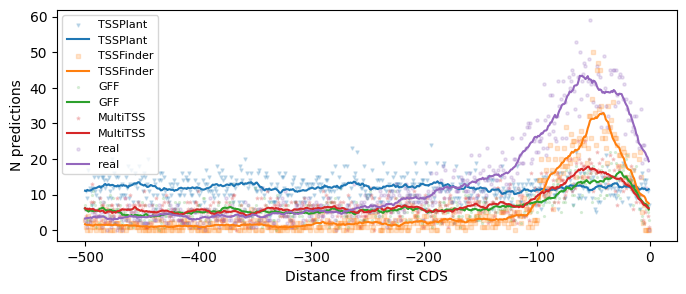

In [30]:
plt.figure(figsize=(8,3))
plt.scatter(y=upstram_tssplant, x=[-i for i in range(1, 501)], s=5, label='TSSPlant', marker='v', alpha=0.2)
plt.plot([-i for i in range(1, 501)], smooth(upstram_tssplant, 10), label='TSSPlant')

plt.scatter(y=upstream_tssfinder, x=[-i for i in range(1, 501)], s=5, label='TSSFinder', marker='s', alpha=0.2)
plt.plot([-i for i in range(1, 501)], smooth(upstream_tssfinder, 10), label='TSSFinder')

plt.scatter(y=upstream_gffmodel, x=[-i for i in range(1, 501)], s=5, label='GFF', marker='1', alpha=0.2)
plt.plot([-i for i in range(1, 501)], smooth(upstream_gffmodel, 10), label='GFF')

plt.scatter(y=upstream_multitss, x=[-i for i in range(1, 501)], s=5, label='MultiTSS', marker='*', alpha=0.2)
plt.plot([-i for i in range(1, 501)], smooth(upstream_multitss, 10), label='MultiTSS')

plt.scatter(y=upstream_realtss, x=[-i for i in range(1, 501)], s=5, label='real', marker='o', alpha=0.2)
plt.plot([-i for i in range(1, 501)], smooth(upstream_realtss, 10), label='real')

plt.xlabel('Distance from first CDS')
plt.ylabel('N predictions')
# plt.title('Comparison of TSS per position distributions')
plt.legend(loc="upper left", fontsize=8)
plt.show()

In [31]:
mtsd = np.array(multitssmodeldata)
gffd = np.array(gffmodeldata)
rmld = np.array(realmodeldata)
tspl = np.array(predtssplant)
tsfn = np.array(predtssfinder)
mtsd.shape, gffd.shape, rmld.shape, tspl.shape, tsfn.shape

((2766, 1000), (2766, 1000), (2766, 1000), (2766, 1000), (2766, 1000))

tssplant 0.3693211488250653 tssfinder 0.14346723608701456


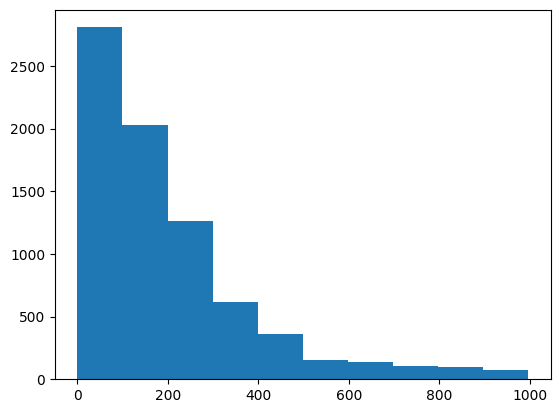

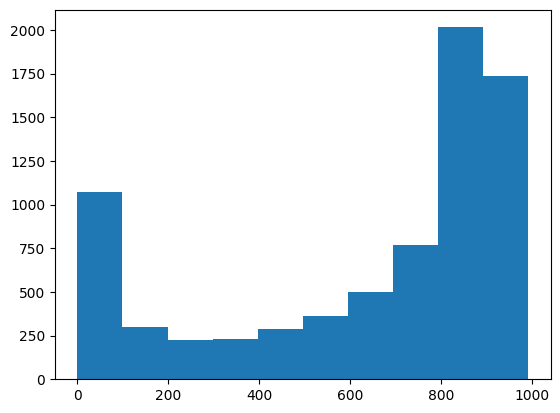

In [33]:
# predictions of plantss and tssfinder
model_tss_pairs = {'plant': [], 'finder': [], 'gff': [], 'multi': []}
tspldists, tsfndists = [],[]
DIST = 100

for r in range(mtsd.shape[0]):
  if np.sum(rmld[r]) < 1: continue
  reals = np.nonzero(rmld[r])[0]
  tsplpreds = np.nonzero(tspl[r])[0]
  tsfpreds = np.nonzero(tsfn[r])[0]
  for rl in reals:
    mmin, gmin = 1e6, 1e6
    for tsplpred in tsplpreds:
      if abs(rl-tsplpred) < abs(mmin-rl): mmin = tsplpred
    if mmin < 1e6:
      tspldists.append(abs(mmin-rl))
      model_tss_pairs['plant'].append((rl, mmin))

    for tsfpred in tsfpreds:
      if abs(rl-tsfpred) < abs(gmin-rl): gmin = tsfpred
    if gmin < 1e6:
      tsfndists.append(abs(gmin-rl))
      model_tss_pairs['finder'].append((rl, gmin))

print('tssplant', sum([1 if x <= DIST else 0 for x in tspldists])/len(tspldists), 'tssfinder', sum([1 if x <= DIST else 0 for x in tsfndists])/len(tsfndists))

plt.hist(tspldists)
plt.show()
plt.hist(tsfndists)
plt.show()

multi 0.08233766233766233 gff 0.06103896103896104


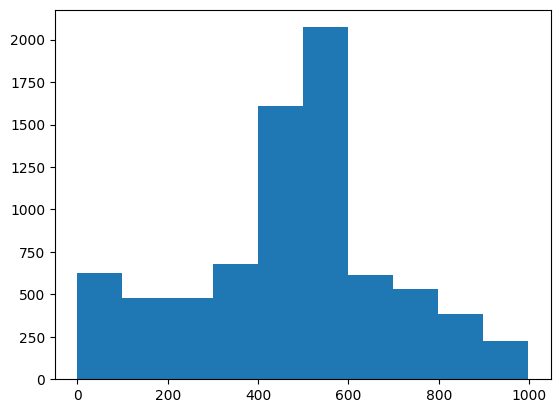

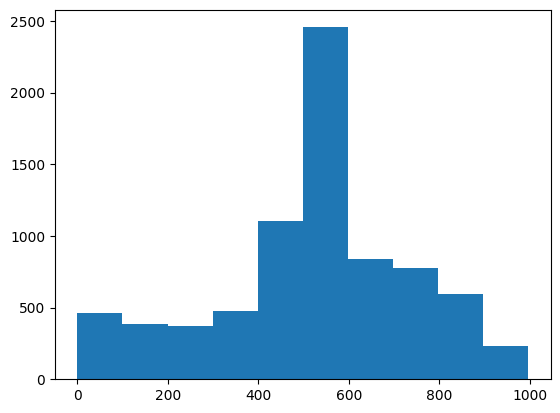

In [34]:
# predictions
rnd = 0.995
mtsddists, gffdists = [],[]
for r in range(mtsd.shape[0]):
  if np.sum(rmld[r]) < 1: continue
  reals = np.nonzero(rmld[r])[0]
  mtsdpreds = np.nonzero(mtsd[r] >= np.max(mtsd[r])*rnd)[0]
  gffpreds = np.nonzero(gffd[r] >= np.max(gffd[r])*rnd)[0]
  for rl in reals:
    mmin, gmin = 1e6, 1e6
    for mtsdpred in mtsdpreds:
      if abs(rl-mtsdpred) < abs(mmin-rl): mmin = mtsdpred
    if mmin < 1e6:
      mtsddists.append(abs(mmin-rl))
      model_tss_pairs['multi'].append((rl, mmin))

    for gffpred in gffpreds:
      if abs(rl-gffpred) < abs(gmin-rl): gmin = gffpred
    if gmin < 1e6:
      gffdists.append(abs(gmin-rl))
      model_tss_pairs['gff'].append((rl, gmin))

print('multi', sum([1 if x <= DIST else 0 for x in mtsddists])/len(mtsddists), 'gff', sum([1 if x <= DIST else 0 for x in gffdists])/len(gffdists))

plt.hist(mtsddists)
plt.show()
plt.hist(gffdists)
plt.show()

<ipython-input-36-4ee67d2639e0>:8: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  handles = legend.legendHandles


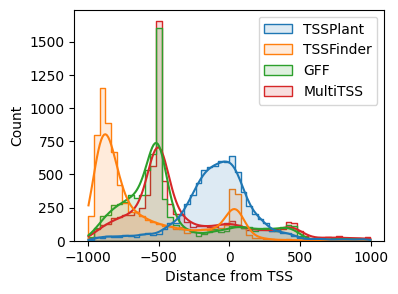

In [36]:
dists_cds, lab = [], []
import seaborn as sns
titles = {'plant':'TSSPlant', 'finder':'TSSFinder', 'gff':'GFF', 'multi':'MultiTSS'}
plt.figure(figsize=(4, 3))
ax1 = plt.axes()
sns.histplot([[i[1]-i[0] for i in model_tss_pairs[m]] for m in model_tss_pairs], kde=True , element='step', alpha=0.15)
legend = ax1.get_legend()
handles = legend.legendHandles
legend.remove()
ax1.legend(handles, titles.values())
# plt.title('Model error histogram')
plt.xlabel('Distance from TSS')
plt.ylabel('Count')
plt.show()

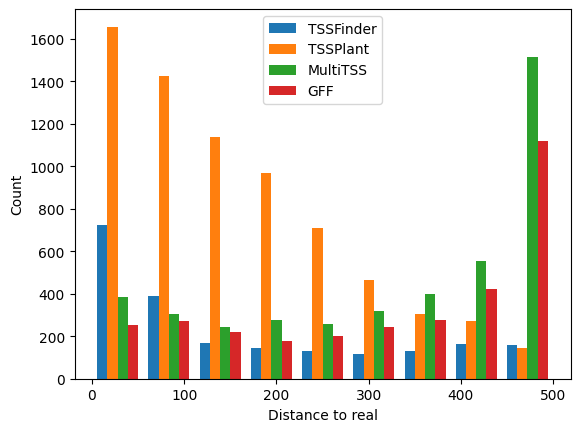

In [37]:
bins = np.linspace(0, 500, 10)
# Create the histograms
histobj = plt.hist([tsfndists,tspldists,mtsddists,gffdists], bins=bins, stacked=False, label=['TSSFinder','TSSPlant', 'MultiTSS', 'GFF'])

# lahko narišeš labels glede na center, ker hist vrne sam katere bine je uporabil, naredi svoje x ticks
# povečaj razdaljo med skupinami stolpcev - lahko uporabiš bar() in podaš kar vrne hist

# plt.title('Histograms of 4 Arrays')

# Add labels to the x-axis and y-axis
plt.xlabel('Distance to real')
plt.ylabel('Count')
plt.legend()

# Show the plot
plt.show()

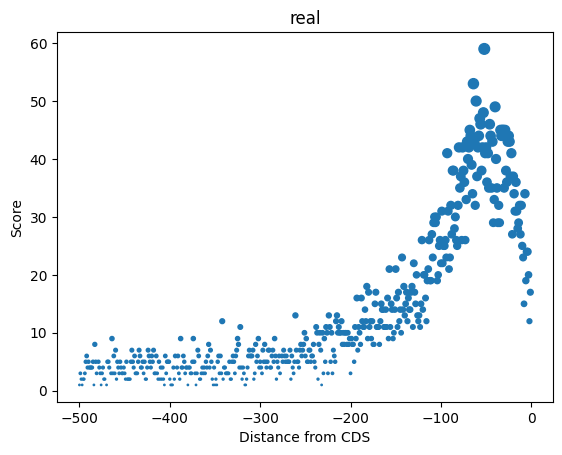

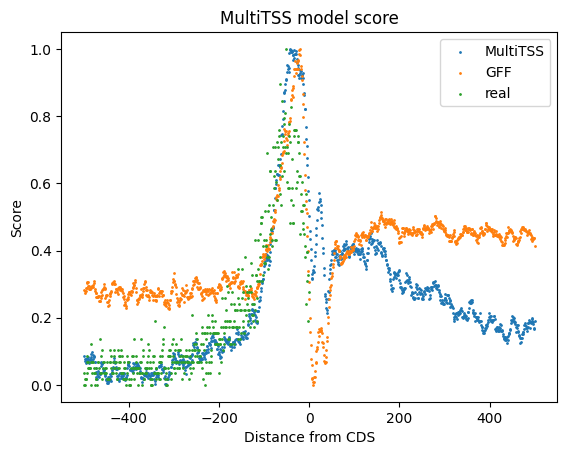

In [38]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
largedist_realcds = {a:b for a,b in dist_realcds.items() if b > 0 }
plt.scatter(y=largedist_realcds.values(), x=largedist_realcds.keys(), s=[v for v in largedist_realcds.values()])
plt.title('real')
plt.xlabel('Distance from CDS')
plt.ylabel('Score')

plt.show()

plt.scatter(y=MinMaxScaler().fit_transform(np.median(mtsd, axis=0).reshape(-1, 1)),
            x=[-i for i in range(-upstream, downstream)][::-1], s=1, label='MultiTSS')
plt.scatter(y=MinMaxScaler().fit_transform(np.median(gffd, axis=0).reshape(-1, 1)), x=[-i for i in range(-upstream, downstream)][::-1], s=1, label='GFF')
plt.scatter(y=MinMaxScaler().fit_transform(np.array(list(largedist_realcds.values())).reshape(-1, 1)), x=largedist_realcds.keys(), s=1, label='real')

plt.title('MultiTSS model score')
plt.xlabel('Distance from CDS')
plt.ylabel('Score')
plt.legend()

plt.show()
# plt.scatter(y=np.mean(gffd, axis=0), x=[-i for i in range(-upstream, downstream)][::-1], s=1)
# plt.title('GFF model score')
# plt.xlabel('Distance from CDS')
# plt.ylabel('Score')
# plt.show()




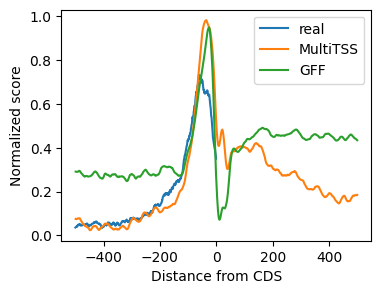

In [39]:
plt.figure(figsize=(4,3))
plt.plot(largedist_realcds.keys(), smooth(MinMaxScaler().fit_transform(np.array(list(largedist_realcds.values())).reshape(-1, 1)), 10), label='real')
# plt.scatter(y=MinMaxScaler().fit_transform(np.array(list(largedist_realcds.values())).reshape(-1, 1)), x=largedist_realcds.keys(), s=3, label='real', alpha=0.2)

plt.plot([-i for i in range(-upstream, downstream)][::-1], smooth(MinMaxScaler().fit_transform(np.median(mtsd, axis=0).reshape(-1, 1)), 10), label='MultiTSS')
#plt.scatter(y=MinMaxScaler().fit_transform(np.median(mtsd, axis=0).reshape(-1, 1)), x=[-i for i in range(-upstream, downstream)][::-1], s=1, label='MultiTSS', alpha=0.2)

plt.plot([-i for i in range(-upstream, downstream)][::-1], smooth(MinMaxScaler().fit_transform(np.median(gffd, axis=0).reshape(-1, 1)), 10), label='GFF')
#plt.scatter(y=MinMaxScaler().fit_transform(np.median(gffd, axis=0).reshape(-1, 1)), x=[-i for i in range(-upstream, downstream)][::-1], s=1, label='GFF', alpha=0.2)


#plt.title('MultiTSS model score')
plt.xlabel('Distance from CDS')
plt.ylabel('Normalized score')
# plt.title('Model score around first CDS site')
plt.legend()
plt.show()